# This notebook illustrates a few tests for the two currently implemented approximations to the Fokker-Planck equation; the Lenard-Bernstein (LB) and Daugherty (DG) implementations. 

# Both are linearized approximations to the non-linear operator. The DG operator, published 5 years after the LB version, improves on the LB version by shifting the moment calculation in each term of the collision operator by the mean velocity. 

# This provides the equation with the ability to conserve momentum and maintain a velocity distribution with non-zero mean velocity. 

# Below, and in the integrated tests in the code, we test each of these phenomena


### Last modified August 16, 2020
### Authored by: Archis Joglekar

In [1]:
from copy import deepcopy
import numpy as np
import os

from matplotlib import pyplot as plt
from tests import test_collisions
from vlapy.core import collisions, step
from tqdm import tqdm

np.set_printoptions(precision=3, suppress=True)

if test_collisions.test_maxwellian_solution() is None:
    print ("Maxwellian Solution Test Passed")
    
if test_collisions.test_density_conservation() is None:
    print ("Density Conservation Test Passed")
    
if test_collisions.test_momentum_conservation() is None:
    print ("Momentum Conservation Test Passed")
    
if test_collisions.test_energy_conservation() is None:
    print ("Energy Conservation Test Passed")

Maxwellian Solution Test Passed
Density Conservation Test Passed
Momentum Conservation Test Passed
Energy Conservation Test Passed


# Let's go through these tests step-by-step
## Testing if a Maxwellian Distribution is the steady state solution to this system

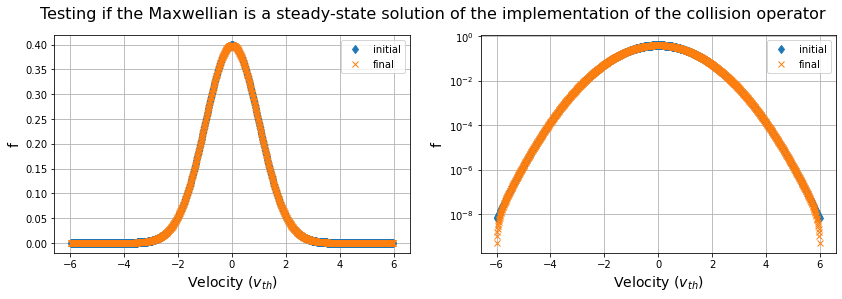

In [2]:
t_end = 32
vshift = 0.

# Get distribution function and other parameters
f, v, nv, nx, nu, dt, dv = test_collisions.__initialize_for_collisions__(vshift=vshift)

# Get the collision step
stuff_for_time_loop = {
    "f": f,
    "v": v,
    "nv": nv,
    "nx": nx,
    "nu": nu,
    "dt": dt,
    "dv": dv,
}

all_params = {
    "fokker-planck": {"type": "lb", "solver": "batched_tridiagonal"},
    "nu": nu,
}

fp_step = step.get_collision_step(
    all_params=all_params, stuff_for_time_loop=stuff_for_time_loop
)

# Go through time loop
f_out = deepcopy(f)
for it in range(t_end):
    f_out = fp_step(f_out)
    
# test that the initial and final distribution functions are equal
np.testing.assert_almost_equal(f, f_out, decimal=4)


# Visualize
fig = plt.figure(figsize=(14,4))
mxplt = fig.add_subplot(121)
mxplt.plot(v, f[0], "d", label="initial")
mxplt.plot(v, f_out[0], "x", label="final")
mxplt.grid()
mxplt.set_xlabel("Velocity ($v_{th}$)", fontsize=14)
mxplt.set_ylabel("f", fontsize=14)
mxplt.legend()

lgmxplt = fig.add_subplot(122)
lgmxplt.semilogy(v, f[0], "d", label="initial")
lgmxplt.semilogy(v, f_out[0], "x", label="final")
lgmxplt.grid()
lgmxplt.set_xlabel("Velocity ($v_{th}$)", fontsize=14)
lgmxplt.set_ylabel("f", fontsize=14)
lgmxplt.legend()

fig.suptitle("Testing if the Maxwellian is a steady-state solution of the implementation of the collision operator", fontsize=16)
fig.savefig(os.getcwd() + "/Maxwell_Solution.png", bbox_inches="tight")

## Next we test the energy conservation of the implementation of the collision operator for a typical set of collision rate and timescale.

100%|██████████| 99/99 [00:01<00:00, 51.67it/s]


Density conservation error = 8.55e-09
Momentum conservation error = -1.11e-16
Energy conservation error = 3.09e-07


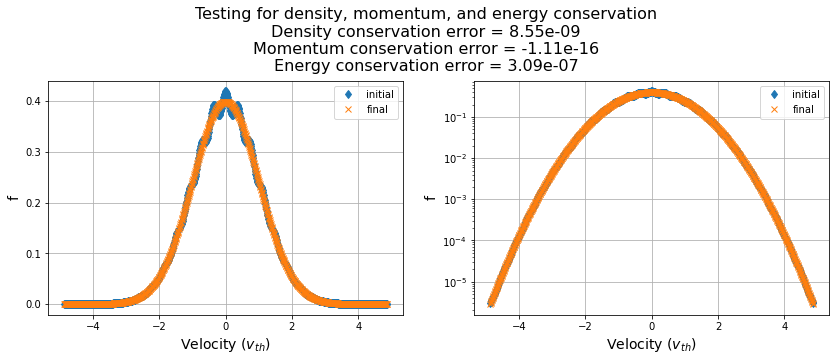

In [3]:
nu = 1e-3
dt = 0.1
v0 = 1.0

f = f*(1+0.05*np.cos(64*np.pi/12*v))

nt = 100

f_out = deepcopy(f)
    
for it in tqdm(range(1,nt)):
    f_out = fp_step(f_out)

temp_in = np.trapz(f, dx=dv)
temp_out = np.trapz(f_out, dx=dv)
n_diff = np.mean(temp_in - temp_out)

print ("Density conservation error = " + str(np.format_float_scientific(n_diff, precision=2)))
np.testing.assert_almost_equal(temp_out, temp_in, decimal=6)

temp_in = np.trapz(f * v, dx=dv)
temp_out = np.trapz(f_out * v, dx=dv)
m_diff = np.mean(temp_in - temp_out)

print ("Momentum conservation error = " + str(np.format_float_scientific(m_diff, precision=2)))
np.testing.assert_almost_equal(temp_out, temp_in, decimal=6)

temp_in = np.trapz(f * v ** 2.0, dx=dv)
temp_out = np.trapz(f_out * v ** 2.0, dx=dv)
e_diff = np.mean(temp_in - temp_out)

print ("Energy conservation error = " + str(np.format_float_scientific(e_diff, precision=2)))
np.testing.assert_almost_equal(temp_out, temp_in, decimal=3)

pltint = 96

# Visualize
fig = plt.figure(figsize=(14,5))
mxplt = fig.add_subplot(121)
mxplt.plot(v[pltint:-pltint], f[0, pltint:-pltint], "d", label="initial")
mxplt.plot(v[pltint:-pltint], f_out[0, pltint:-pltint], "x", label="final")
mxplt.grid()
mxplt.set_xlabel("Velocity ($v_{th}$)", fontsize=14)
mxplt.set_ylabel("f", fontsize=14)
mxplt.legend()

lgmxplt = fig.add_subplot(122)
lgmxplt.semilogy(v[pltint:-pltint], f[0, pltint:-pltint], "d", label="initial")
lgmxplt.semilogy(v[pltint:-pltint], f_out[0, pltint:-pltint], "x", label="final")
lgmxplt.grid()
lgmxplt.set_xlabel("Velocity ($v_{th}$)", fontsize=14)
lgmxplt.set_ylabel("f", fontsize=14)
lgmxplt.legend()

title_str = "Testing for density, momentum, and energy conservation"
title_str += "\nDensity conservation error = " + str(np.format_float_scientific(n_diff, precision=2))
title_str += "\nMomentum conservation error = " + str(np.format_float_scientific(m_diff, precision=2))
title_str += "\nEnergy conservation error = " + str(np.format_float_scientific(e_diff, precision=2))
fig.suptitle(title_str, fontsize=16)
fig.subplots_adjust(top=.775)
fig.savefig(os.getcwd() + "/LB_conservation.png", bbox_inches="tight")

## Now we show that the Lenard-Bernstein formulation of the collision operator does not respect energy and momentum conservation when the velocity distribution is not centered at 0. The operator is designed to return the distribution to a mean velocity of 0.

100%|██████████| 99/99 [00:01<00:00, 52.92it/s]


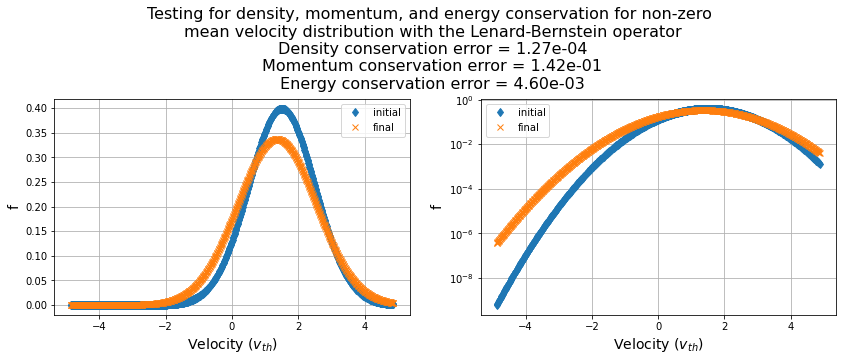

In [4]:
t_end = 32
vshift = 1.5

# Get distribution function and other parameters
f, v, nv, nx, nu, dt, dv = test_collisions.__initialize_for_collisions__(vshift=vshift)

nt = 100

f_out = f.copy()

for it in tqdm(range(1,nt)):
    f_out = fp_step(f_out)

temp_in = np.trapz(f, dx=dv)
temp_out = np.trapz(f_out, dx=dv)
n_diff = np.mean(temp_in - temp_out)
np.testing.assert_almost_equal(temp_out, temp_in, decimal=4)

temp_in = np.trapz(f * v, dx=dv)
temp_out = np.trapz(f_out * v, dx=dv)
m_diff = np.mean(temp_in - temp_out)
# np.testing.assert_almost_equal(temp_out, temp_in, decimal=6)

temp_in = np.trapz(f * v ** 2.0, dx=dv)
temp_out = np.trapz(f_out * v ** 2.0, dx=dv)
e_diff = np.mean(temp_in - temp_out)

pltint = 96

# Visualize
fig = plt.figure(figsize=(14,5))
mxplt = fig.add_subplot(121)
mxplt.plot(v[pltint:-pltint], f[0, pltint:-pltint], "d", label="initial")
mxplt.plot(v[pltint:-pltint], f_out[0, pltint:-pltint], "x", label="final")
mxplt.grid()
mxplt.set_xlabel("Velocity ($v_{th}$)", fontsize=14)
mxplt.set_ylabel("f", fontsize=14)
mxplt.legend()

lgmxplt = fig.add_subplot(122)
lgmxplt.semilogy(v[pltint:-pltint], f[0, pltint:-pltint], "d", label="initial")
lgmxplt.semilogy(v[pltint:-pltint], f_out[0, pltint:-pltint], "x", label="final")
lgmxplt.grid()
lgmxplt.set_xlabel("Velocity ($v_{th}$)", fontsize=14)
lgmxplt.set_ylabel("f", fontsize=14)
lgmxplt.legend()


title_str = "Testing for density, momentum, and energy conservation for non-zero \nmean velocity distribution with the Lenard-Bernstein operator"
title_str += "\nDensity conservation error = " + str(np.format_float_scientific(n_diff, precision=2))
title_str += "\nMomentum conservation error = " + str(np.format_float_scientific(m_diff, precision=2))
title_str += "\nEnergy conservation error = " + str(np.format_float_scientific(e_diff, precision=2))
fig.suptitle(title_str, fontsize=16)
fig.subplots_adjust(top=.725)
fig.savefig(os.getcwd() + "/LB_no_conservation.png", bbox_inches="tight")

## In contrast, the Dougherty operator does respect density, momentum, and energy conservation for non-zero mean velocity distributions

100%|██████████| 99/99 [00:02<00:00, 47.38it/s]


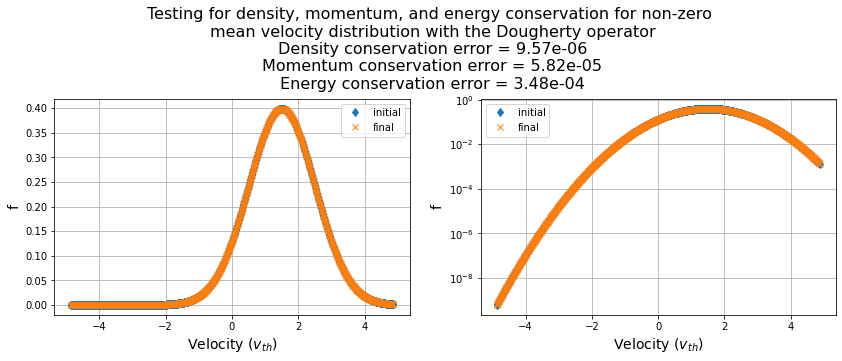

In [5]:
vshift = 1.5

# Get distribution function and other parameters
f, v, nv, nx, nu, dt, dv = test_collisions.__initialize_for_collisions__(vshift=vshift)

# Get the collision step
stuff_for_time_loop = {
    "f": f,
    "v": v,
    "nv": nv,
    "nx": nx,
    "nu": nu,
    "dt": dt,
    "dv": dv,
}

all_params = {
    "fokker-planck": {"type": "dg", "solver": "batched_tridiagonal"},
    "nu": nu,
}

fp_step = step.get_collision_step(
    all_params=all_params, stuff_for_time_loop=stuff_for_time_loop
)

nt = 100

f_out = f.copy()

for it in tqdm(range(1,nt)):
    f_out = fp_step(f_out)
    
    
temp_in = np.trapz(f, dx=dv)
temp_out = np.trapz(f_out, dx=dv)
n_diff = np.mean(temp_in - temp_out)
np.testing.assert_almost_equal(temp_out, temp_in, decimal=4)

temp_in = np.trapz(f * v, dx=dv)
temp_out = np.trapz(f_out * v, dx=dv)
m_diff = np.mean(temp_in - temp_out)
# np.testing.assert_almost_equal(temp_out, temp_in, decimal=6)

temp_in = np.trapz(f * v ** 2.0, dx=dv)
temp_out = np.trapz(f_out * v ** 2.0, dx=dv)
e_diff = np.mean(temp_in - temp_out)

pltint = 96

# Visualize
fig = plt.figure(figsize=(14,5))
mxplt = fig.add_subplot(121)
mxplt.plot(v[pltint:-pltint], f[0, pltint:-pltint], "d", label="initial")
mxplt.plot(v[pltint:-pltint], f_out[0, pltint:-pltint], "x", label="final")
mxplt.grid()
mxplt.set_xlabel("Velocity ($v_{th}$)", fontsize=14)
mxplt.set_ylabel("f", fontsize=14)
mxplt.legend()

lgmxplt = fig.add_subplot(122)
lgmxplt.semilogy(v[pltint:-pltint], f[0, pltint:-pltint], "d", label="initial")
lgmxplt.semilogy(v[pltint:-pltint], f_out[0, pltint:-pltint], "x", label="final")
lgmxplt.grid()
lgmxplt.set_xlabel("Velocity ($v_{th}$)", fontsize=14)
lgmxplt.set_ylabel("f", fontsize=14)
lgmxplt.legend()

title_str = "Testing for density, momentum, and energy conservation for non-zero \nmean velocity distribution with the Dougherty operator"
title_str += "\nDensity conservation error = " + str(np.format_float_scientific(n_diff, precision=2))
title_str += "\nMomentum conservation error = " + str(np.format_float_scientific(m_diff, precision=2))
title_str += "\nEnergy conservation error = " + str(np.format_float_scientific(e_diff, precision=2))
fig.suptitle(title_str, fontsize=16)
fig.subplots_adjust(top=.725)
fig.savefig(os.getcwd() + "/DG_conservation.png", bbox_inches="tight")